<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/experiments_analysis_Julia_based_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [432]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

# Helpers for plotting the trajectories of the weights of the neurons

In [433]:
def plot_trajectories(data_row):
  convergence_neurons_incoming_x = []
  convergence_neurons_incoming_y = []
  convergence_neurons_outgoing = []

  for i in range(0, int(data_row['student size'])):
    neuron_traj_x = np.fromstring(data_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')
    plt.plot(neuron_traj_x, neuron_traj_y)
  
    convergence_neurons_incoming_x.append(neuron_traj_x[-1])
    convergence_neurons_incoming_y.append(neuron_traj_y[-1])

    neuron_a = float(data_row['neuron_' + str(i) + '_a'].values[0])
    convergence_neurons_outgoing.append(neuron_a)

  teacher_neurons_x = np.fromstring(data_row['teacher_neurons_x'].values[0][1 : -1], dtype=float, sep=',')
  teacher_neurons_y = np.fromstring(data_row['teacher_neurons_y'].values[0][1 : -1], dtype=float, sep=',')
  plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

  plt.scatter(convergence_neurons_incoming_x,
            convergence_neurons_incoming_y,
            c = convergence_neurons_outgoing,
            cmap=matplotlib.cm.jet)
  plt.colorbar()

# Read the data from the .csv file

In [434]:
data = pd.read_csv('fixed_points.csv', float_precision='round_trip')

len(data)

1000

In [435]:
data.head()

,activation,N,Ninner,seed,maxtime,loss,smallest_heg,gradient_norm,w11,w21,w31,w41,w51,w12,w22,w32,w42,w52,a1,a2,a3,a4,a5
0,sigmoid,10,100000,1,3600,7.340982e-05,9.070762e-12,8.036297e-10,-1.296618,-0.902262,-1.277936,0.194223,-0.730563,1.042003,-0.585449,1.029128,-0.054116,1.487154,1.097378e+01,-0.454981,-11.366674,0.776118,7.176519e-02
1,sigmoid,10,100000,10,3600,3.064903e-31,-7.535396e-17,3.620881e-16,-0.200000,-0.500000,-0.500001,-0.100000,-0.600000,-0.600000,0.500000,0.500000,0.600000,-0.500000,1.000000e+00,-0.920254,-0.079746,1.000000,-1.000000e+00
2,sigmoid,10,100000,100,3600,1.701555e-32,-8.088575e-19,2.537475e-17,0.441250,-0.600000,-0.500000,-0.100000,-0.200000,-0.603799,-0.500000,0.500000,0.600000,-0.600000,1.779090e-14,-1.000000,-1.000000,1.000000,1.000000e+00
3,sigmoid,10,100000,1000,3600,1.510018e-32,1.942791e-19,7.187402e-17,-0.500000,-0.100000,-0.600000,-0.200000,0.510745,0.500000,0.600000,-0.500000,-0.600000,-0.408655,-1.000000e+00,1.000000,-1.000000,1.000000,-3.185828e-15
4,sigmoid,10,100000,101,3600,9.824220e-05,1.479210e-10,1.013867e-09,1.420720,1.946299,-0.805450,-0.009467,-1.455685,-0.961272,1.627585,-0.480423,0.002230,0.980023,6.941624e+00,0.047830,-0.435888,-13.146253,6.592686e+00


# Models

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [436]:
torch.set_default_dtype(torch.float64)
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

Teacher model

In [437]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False)
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.DoubleTensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Dataset

In [438]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.DoubleTensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Labels

In [439]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

# Pytorch-based helper for computing the Hessian

In [440]:
def eval_hessian(loss_grad, model):
  cnt = 0
  for g in loss_grad:
      g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
      cnt = 1
  grad_norm = torch.norm(g_vector)
  l = g_vector.size(0)
  hessian = torch.zeros((l, l), dtype = torch.float64)
  for idx in range(l):
      grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
      cnt = 0
      for g in grad2rd: 
          g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
          cnt = 1
      hessian[idx] = g2
  # Symmetrize the Hessian.
  hessian = (hessian + hessian.T) / 2
  return grad_norm.detach().numpy(), hessian.detach().numpy()

# Selection of high loss points

In [441]:
max_loss_data = data[data['loss'] >= 1e-6]
len(max_loss_data)

434

## Select the point with minimum eigenvalue (in magnitude)

### Helper for extracting the weights from one data point.

In [442]:
def extract_weights(data_point):
  incoming_weights_x = [data_point['w11'],
                      data_point['w21'],
                      data_point['w31'],
                      data_point['w41'],
                      data_point['w51']]
  incoming_weights_y = [data_point['w12'],
                      data_point['w22'],
                      data_point['w32'],
                      data_point['w42'],
                      data_point['w52']]
  outgoing_weights = [data_point['a1'],
                    data_point['a2'],
                    data_point['a3'],
                    data_point['a4'],
                    data_point['a5']]
  return incoming_weights_x, incoming_weights_y, outgoing_weights

In [443]:
# sample_point = max_loss_data[max_loss_data['smallest_heg'] == min(abs(max_loss_data['smallest_heg']))]
sample_point = max_loss_data.sample()
for _, sample_point in max_loss_data.sample().iterrows():
  pass
sample_point

activation        sigmoid
N                      10
Ninner             100000
seed                  832
maxtime              3600
loss             0.000082
smallest_heg     0.000001
gradient_norm         0.0
w11              -1.89492
w21              0.964663
w31             -0.396501
w41              0.798279
w51               1.01789
w12              -2.29635
w22              1.183332
w32              0.124409
w42              0.720728
w52             -0.842159
a1              -0.088745
a2               -0.44073
a3              -0.550313
a4               0.816283
a5               0.263494
Name: 815, dtype: object

In [444]:
sample_point['loss']

8.157146234378553e-05

In [445]:
sample_point['gradient_norm']

2.2748326415079776e-11

In [446]:
sample_point['smallest_heg']

1.1504062992514232e-06

In [447]:
incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(sample_point)
print(incoming_weights_x)
print(incoming_weights_y)
print(outgoing_weights)

[-1.8949202584816844, 0.9646625966308273, -0.3965006310026573, 0.7982787984740194, 1.0178904125591792]
[-2.296350253081869, 1.1833322085349054, 0.12440884199583103, 0.7207283433444962, -0.8421593887568282]
[-0.0887447807657592, -0.44072980283860286, -0.5503127926722067, 0.8162834632669603, 0.2634935401585935]


In [448]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

## Plotting of the neuron point

Text(0, 0.5, 'w2')

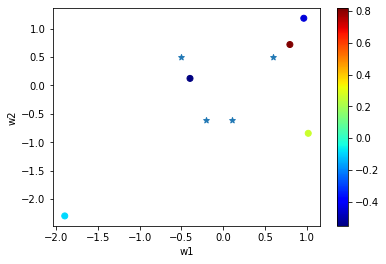

In [449]:
plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

plt.scatter(incoming_weights_x,
            incoming_weights_y,
            c = outgoing_weights,
            cmap = matplotlib.cm.jet)

plt.colorbar()
plt.xlabel('w1')
plt.ylabel('w2')

In [450]:
# max_loss_data[abs(max_loss_data['w31'] - teacher_neurons_x[0]) == min(abs(max_loss_data['w31'] - teacher_neurons_x[0]) )]
# sample_point = max_loss_data[max_loss_data['smallest_heg'] == min(abs(max_loss_data['smallest_heg']))]

In [451]:


# for index, row in max_loss_data.iterrows():
#   incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(row)

#   plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")
#   plt.scatter(incoming_weights_x,
#             incoming_weights_y,
#             c = outgoing_weights,
#             cmap = matplotlib.cm.jet)

#   plt.colorbar()
#   plt.xlabel('w1')
#   plt.ylabel('w2')


## Pytorch-based eigenvalue computation

In [452]:
w_in = torch.DoubleTensor([[incoming_weights_x[0], incoming_weights_y[0]],
                           [incoming_weights_x[1], incoming_weights_y[1]],
                           [incoming_weights_x[2], incoming_weights_y[2]],
                           [incoming_weights_x[3], incoming_weights_y[3]],
                           [incoming_weights_x[4], incoming_weights_y[4]]])
w_out = torch.DoubleTensor([outgoing_weights])
dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))

print('loss at the end: ', nn.MSELoss()(dummy_model(dataset), y_labels))
print('gradient norm at the end: ', grad_norm)
print('smallest eigenvalue at the end: ', smallest_eigenvalue)

loss at the end:  tensor(8.1571e-05, grad_fn=<MseLossBackward0>)
gradient norm at the end:  2.2748326929869714e-11
smallest eigenvalue at the end:  1.1504062988283993e-06


## Smallest eigenvalue using JAX

In [453]:
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32)

jnp_inputs = jnp.array(construct_dataset(), dtype=jnp.float64)
jnp_labels = jnp.array(teacher_model(dataset).detach(), dtype=jnp.float64)

def predict(w_in, w_out):
  return w_out @ jnp.transpose(jax_nn.sigmoid(jnp_inputs @ jnp.transpose(w_in)))

w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
                  [incoming_weights_x[1], incoming_weights_y[1]],
                  [incoming_weights_x[2], incoming_weights_y[2]],
                  [incoming_weights_x[3], incoming_weights_y[3]],
                  [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
w_out = jnp.array(outgoing_weights, dtype=jnp.float64)

### Loss in JAX

Loss of the network computed in JAX.

In [454]:
def loss(w):
  w_in = w[0 : 2 * H_student].reshape(D_in, H_student).T
  w_out = w[2 * H_student : ].reshape(1, H_student)
  preds = predict(w_in, w_out).T
  return jnp.mean(jnp.mean(jnp.square(preds - jnp_labels)))
print(loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))))

8.15714623437858e-05


### Hessian in JAX

In [455]:
from jax import jacfwd, jacrev
import jax

def hessian(f):
    return jacfwd(jacrev(f))

H = hessian(loss)(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

### Eigenvalues in JAX

In [456]:
evals, evectors = jnp.linalg.eig(H)

# Sanity check
for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
  assert eval == 0

evals = jnp.array([jax.lax.real(eval) for eval in evals])
print(evals)
smallest_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])

[2.5822776609723732e+00 1.2193302184021027e+00 8.2309495052978732e-01
 1.1582295195075304e-01 5.5216173741704018e-02 7.9609081124451548e-03
 4.7726457109950483e-03 2.4482510220375439e-03 1.4970750724003013e-03
 5.4771453848328263e-04 2.7177420535749036e-04 1.1423496357215562e-04
 4.5973713451654792e-05 1.9117372886607259e-06 1.1504062997586390e-06]


## Perturbation (based on JAX evectors)

### For one random element

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'smallest eval')

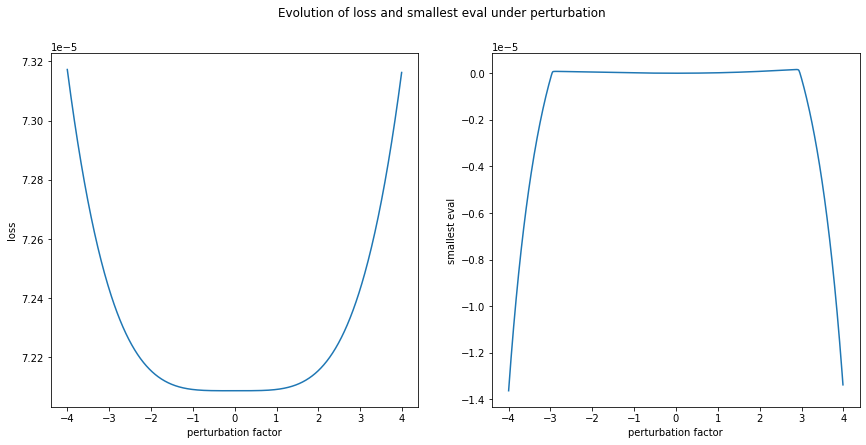

In [430]:
old_loss = loss(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))

perturb_lower_bound = -4.0
perturb_uper_bound = 4.0
perturb_step = 0.01

perturb_losses = []
perturb_evals = []

weights = jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))
for eps in np.arange(perturb_lower_bound, perturb_uper_bound, perturb_step):
  new_weights = weights + eps * smallest_evector
  
  H = hessian(loss)(new_weights)
  H = (H + H.T) / 2
  evals, _ = jnp.linalg.eig(H)

  perturb_evals.append(min(evals))
  perturb_losses.append(loss(new_weights))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14.5, 6.5)
fig.suptitle('Evolution of loss and smallest eval under perturbation')
ax1.plot(np.arange(perturb_lower_bound, perturb_uper_bound, perturb_step), perturb_losses)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('perturbation factor')
ax1.set_ylabel('loss')

ax2.plot(np.arange(perturb_lower_bound, perturb_uper_bound, perturb_step), perturb_evals)
ax2.set_xlabel('perturbation factor')
ax2.set_ylabel('smallest eval')

### For the entire set of high loss points

In [431]:
# num_saddles = 0
# num_local_minima = 0
# num_total = len(max_loss_data)
# max_diff = -float("inf")

# for index, row in max_loss_data.iterrows():
#   old_loss = row['loss']
#   incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(row)

#   w_in = jnp.array([[incoming_weights_x[0], incoming_weights_y[0]],
#                   [incoming_weights_x[1], incoming_weights_y[1]],
#                   [incoming_weights_x[2], incoming_weights_y[2]],
#                   [incoming_weights_x[3], incoming_weights_y[3]],
#                   [incoming_weights_x[4], incoming_weights_y[4]]], dtype=jnp.float64)
#   w_out = jnp.array(outgoing_weights, dtype=jnp.float64)
#   weights = jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student))

#   H = hessian(loss)(jnp.append(w_in.T.reshape(D_in * H_student), w_out.reshape(H_student)))
#   H = (H + H.T) / 2
#   evals, evectors = jnp.linalg.eig(H)

#   # Sanity check
#   for eval in jnp.array([jax.lax.imag(eval) for eval in evals]):
#     assert eval == 0

#   evals = jnp.array([jax.lax.real(eval) for eval in evals])
#   smallest_evector = jnp.array([jax.lax.real(elem) for elem in evectors[:, jnp.argmin(evals)]])

#   for eps in np.arange(-0.3, 0.3, 0.01):
#     new_weights = weights + eps * smallest_evector
#     # print(old_loss, loss(new_weights))
#     # print(old_loss - loss(new_weights) - old_loss / 100.0)
#     max_diff = max(max_diff, old_loss - loss(new_weights))

# print('max diff between the original loss and the computed loss: ', max_diff)